In [1]:
%matplotlib inline
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
train = np.loadtxt('digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('digit/test.csv', delimiter=',', skiprows=1)

In [40]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [48]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

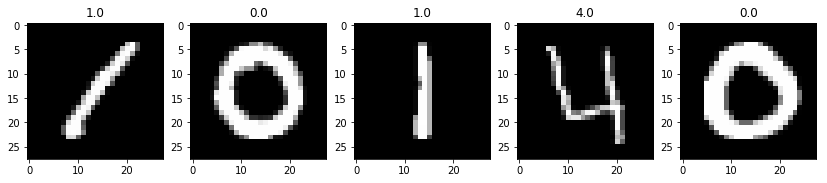

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


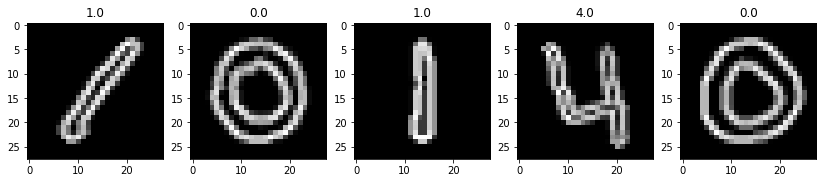

In [35]:
fig = plt.figure(figsize=(20, 10))
kernel = np.array([[1,0,-1]])
kernel2 = np.array([[1],[0],[-1]])

for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    dx = cv2.filter2D(img,-1,kernel)
    dy = cv2.filter2D(img,-1,kernel2)
    g = np.sqrt(dx*dx + dy*dy)
    tetta = np.arctan(dy/dx)
    #print(dst)
    plt.imshow(g, cmap='gray');
    #plt.imshow(tetta, cmap='gray')
    subplot.set_title('%s' % train_label[i - 1]);



## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [46]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [56]:
kernel = np.array([[-1,0,1]])
kernel2 = np.array([[-1],[0],[1]])

train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.filter2D(train_img[i],-1,kernel)
    train_sobel_y[i] = cv2.filter2D(train_img[i],-1,kernel2)

test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.filter2D(test_img[i],-1,kernel)
    test_sobel_y[i] = cv2.filter2D(test_img[i],-1,kernel2)

(42000, 28, 28)
42000


## Вычисляем угол и длину вектора градиента

In [57]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

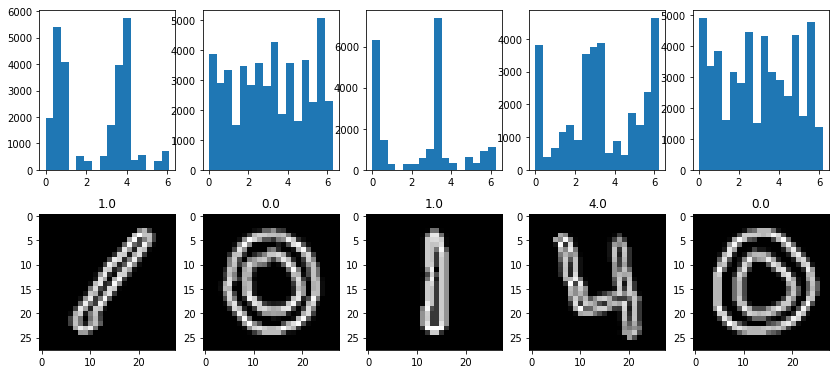

In [58]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [59]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist
    
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [60]:
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [78]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2, random_state=42)



## Собираем полносвязную сеть для обучения

In [62]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(32,
                             input_dim=x_train.shape[1],
                             activation='relu'))

model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Выводим информацию о модели

In [63]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
Total params: 874
Trainable params: 874
Non-trainable params: 0
_________________________________________________________________


## One hot encoding разметки

In [64]:
y_train.shape

(33600,)

In [65]:
from keras.utils import np_utils
y_train_labels = np_utils.to_categorical(y_train)

## Запускаем обучение

In [66]:
model.fit(x_train, y_train_labels, 
          batch_size=32, validation_split=0.2,
          epochs=10)

Train on 26880 samples, validate on 6720 samples
Epoch 1/10
26880/26880 [==============================] - 1s 49us/step - loss: 1.8163 - acc: 0.3456 - val_loss: 1.5339 - val_acc: 0.4540
Epoch 2/10
26880/26880 [==============================] - 1s 43us/step - loss: 1.4584 - acc: 0.4718 - val_loss: 1.4163 - val_acc: 0.4830
Epoch 3/10
26880/26880 [==============================] - 1s 44us/step - loss: 1.3778 - acc: 0.5038 - val_loss: 1.3519 - val_acc: 0.5086
Epoch 4/10
26880/26880 [==============================] - 1s 42us/step - loss: 1.3252 - acc: 0.5240 - val_loss: 1.3024 - val_acc: 0.5345
Epoch 5/10
26880/26880 [==============================] - 1s 43us/step - loss: 1.2856 - acc: 0.5379 - val_loss: 1.2683 - val_acc: 0.5435
Epoch 6/10
26880/26880 [==============================] - 1s 45us/step - loss: 1.2561 - acc: 0.5472 - val_loss: 1.2426 - val_acc: 0.5574
Epoch 7/10
26880/26880 [==============================] - 1s 43us/step - loss: 1.2353 - acc: 0.5587 - val_loss: 1.2239 - val_acc:

In [81]:
y_train_labels.shape

(33600, 10)

## Предсказываем класс объекта

In [83]:
from sklearn.linear_model import LogisticRegression
cls = LogisticRegression()
cls.fit(x_train, y_train)

x_pred = cls.predict(x_val)

from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, x_pred))


/home/user/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/user/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy: 0.5352380952380953


In [68]:
pred_val = model.predict_classes(x_val)

In [69]:
pred_proba = model.predict_proba(x_val)

## Оцениваем качество решение на валидационной выборке

In [70]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.5658333333333333


In [71]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.40      0.32      0.36       816
         1.0       0.89      0.96      0.92       909
         2.0       0.43      0.34      0.38       846
         3.0       0.54      0.62      0.58       937
         4.0       0.67      0.62      0.65       839
         5.0       0.51      0.57      0.54       702
         6.0       0.38      0.31      0.34       785
         7.0       0.70      0.73      0.72       893
         8.0       0.45      0.56      0.50       835
         9.0       0.52      0.55      0.54       838

   micro avg       0.57      0.57      0.57      8400
   macro avg       0.55      0.56      0.55      8400
weighted avg       0.56      0.57      0.56      8400



In [72]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[259  19  70  40  21  27 126   9 200  45]
 [  1 872   1   0  17   0   5   5   1   7]
 [ 47   0 286 169   5 152  24  47  90  26]
 [ 29   0  80 585   0 134   4   3  87  15]
 [ 10  44   6   5 524   0  46  87   9 108]
 [  7   0  70 159   1 402   4  13  45   1]
 [126   8  72  17  63   8 240  39  87 125]
 [  7  20  27   5  67  23  42 654   5  43]
 [103   3  24  77   8  36  56  11 467  50]
 [ 52  13  33  17  71   8  77  63  40 464]]


## Предсказания на тестовыйх данных

In [73]:
pred_test = model.predict_classes(test_hist)

## Визуализируем предсказания

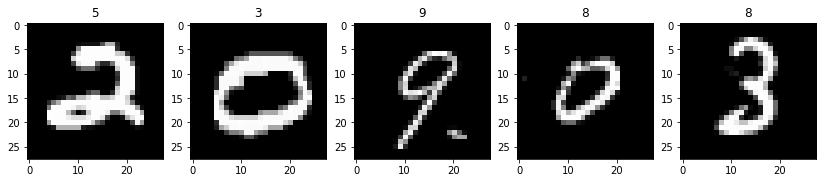

In [74]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [25]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [26]:
# Your submission scored 0.59843